# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        svm=LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
        num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        train_acc=np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_acc=np.mean(y_val == y_val_pred)
        results[(lr,reg)]=(train_acc,val_acc)
        print('learning_rate=%f,regularization_strengths=%f,Valid_acc=%f'%(lr,reg,val_acc))
        if val_acc>best_val:
            best_val=val_acc
            best_svm=svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 90.530990
iteration 100 / 1500: loss 88.918280
iteration 200 / 1500: loss 87.337078
iteration 300 / 1500: loss 85.786107
iteration 400 / 1500: loss 84.264395
iteration 500 / 1500: loss 82.770994
iteration 600 / 1500: loss 81.317045
iteration 700 / 1500: loss 79.879180
iteration 800 / 1500: loss 78.479510
iteration 900 / 1500: loss 77.098748
iteration 1000 / 1500: loss 75.750710
iteration 1100 / 1500: loss 74.425716
iteration 1200 / 1500: loss 73.133837
iteration 1300 / 1500: loss 71.862909
iteration 1400 / 1500: loss 70.624875
learning_rate=0.000000,regularization_strengths=50000.000000,Valid_acc=0.136000
iteration 0 / 1500: loss 785.640544
iteration 100 / 1500: loss 644.786359
iteration 200 / 1500: loss 529.490411
iteration 300 / 1500: loss 435.095010
iteration 400 / 1500: loss 357.827583
iteration 500 / 1500: loss 294.565676
iteration 600 / 1500: loss 242.777780
iteration 700 / 1500: loss 200.381167
iteration 800 / 1500: loss 165.673800
iteration 900 / 1500: 

In [5]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.418


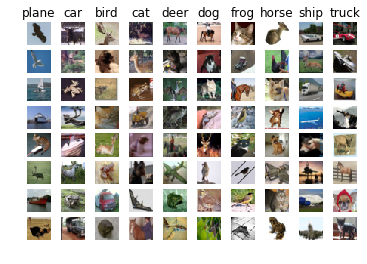

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$
From a small image, they are quiet similar with each other in a vectorized way. Yes, but that's not enough.



## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [8]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
best_acc = -1
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
learning_rates = np.linspace(0.5, 1.2, 5)
regularization_strengths = np.linspace(0.01, 0.02, 10)
for lr in learning_rates:
    for reg in regularization_strengths:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        net.train(X_train_feats, y_train, X_val_feats, y_val,
                    num_iters=1000, learning_rate=lr, learning_rate_decay=0.95,
                    reg=reg, verbose=True)
        val_acc=np.mean(net.predict(X_val_feats) == y_val)
        print ('lr = %f, reg = %f, Valid_accuracy: %f' %(lr, reg, val_acc))
        if val_acc > best_acc:
            best_acc = val_acc
            best_net = net

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# Sorry for havn't find good hyperparameters.

iteration 0 / 1000: loss 2.302593
iteration 100 / 1000: loss 1.647543
iteration 200 / 1000: loss 1.600890
iteration 300 / 1000: loss 1.549998
iteration 400 / 1000: loss 1.611909
iteration 500 / 1000: loss 1.564208
iteration 600 / 1000: loss 1.592147
iteration 700 / 1000: loss 1.600528
iteration 800 / 1000: loss 1.545929
iteration 900 / 1000: loss 1.615209
lr = 0.500000, reg = 0.010000, Valid_accuracy: 0.517000
iteration 0 / 1000: loss 2.302594
iteration 100 / 1000: loss 1.691388
iteration 200 / 1000: loss 1.617777
iteration 300 / 1000: loss 1.612558
iteration 400 / 1000: loss 1.558100
iteration 500 / 1000: loss 1.597641
iteration 600 / 1000: loss 1.593451
iteration 700 / 1000: loss 1.543068
iteration 800 / 1000: loss 1.578277
iteration 900 / 1000: loss 1.576093
lr = 0.500000, reg = 0.011111, Valid_accuracy: 0.498000
iteration 0 / 1000: loss 2.302595
iteration 100 / 1000: loss 1.711135
iteration 200 / 1000: loss 1.597677
iteration 300 / 1000: loss 1.614212
iteration 400 / 1000: loss 1.5

lr = 0.675000, reg = 0.020000, Valid_accuracy: 0.495000
iteration 0 / 1000: loss 2.302593
iteration 100 / 1000: loss 1.598220
iteration 200 / 1000: loss 1.613643
iteration 300 / 1000: loss 1.613687
iteration 400 / 1000: loss 1.592309
iteration 500 / 1000: loss 1.576795
iteration 600 / 1000: loss 1.535763
iteration 700 / 1000: loss 1.572145
iteration 800 / 1000: loss 1.596865
iteration 900 / 1000: loss 1.626855
lr = 0.850000, reg = 0.010000, Valid_accuracy: 0.507000
iteration 0 / 1000: loss 2.302594
iteration 100 / 1000: loss 1.631106
iteration 200 / 1000: loss 1.643675
iteration 300 / 1000: loss 1.573869
iteration 400 / 1000: loss 1.586866
iteration 500 / 1000: loss 1.579418
iteration 600 / 1000: loss 1.573539
iteration 700 / 1000: loss 1.646397
iteration 800 / 1000: loss 1.601722
iteration 900 / 1000: loss 1.583035
lr = 0.850000, reg = 0.011111, Valid_accuracy: 0.517000
iteration 0 / 1000: loss 2.302595
iteration 100 / 1000: loss 1.641824
iteration 200 / 1000: loss 1.627021
iteration 

iteration 800 / 1000: loss 1.688191
iteration 900 / 1000: loss 1.703650
lr = 1.025000, reg = 0.020000, Valid_accuracy: 0.465000
iteration 0 / 1000: loss 2.302593
iteration 100 / 1000: loss 1.587644
iteration 200 / 1000: loss 1.593867
iteration 300 / 1000: loss 1.576903
iteration 400 / 1000: loss 1.601049
iteration 500 / 1000: loss 1.577473
iteration 600 / 1000: loss 1.596101
iteration 700 / 1000: loss 1.566628
iteration 800 / 1000: loss 1.602812
iteration 900 / 1000: loss 1.554061
lr = 1.200000, reg = 0.010000, Valid_accuracy: 0.495000
iteration 0 / 1000: loss 2.302594
iteration 100 / 1000: loss 1.630112
iteration 200 / 1000: loss 1.649865
iteration 300 / 1000: loss 1.641369
iteration 400 / 1000: loss 1.509725
iteration 500 / 1000: loss 1.562396
iteration 600 / 1000: loss 1.599576
iteration 700 / 1000: loss 1.578356
iteration 800 / 1000: loss 1.648438
iteration 900 / 1000: loss 1.573512
lr = 1.200000, reg = 0.011111, Valid_accuracy: 0.495000
iteration 0 / 1000: loss 2.302595
iteration 

In [9]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.506
